# Lecture Notes 3: Rounding, Overflow, Linear Algebra

## Rounding

Let's start with a weird experiment:

In [1]:
import numpy
a = numpy.array([1,10,100,1000],dtype='float32')
print(a)

[   1.   10.  100. 1000.]


In [2]:
print((a + 1e9) - 1e9)

[   0.    0.  128. 1024.]


Now, let's repeat the experiment with higher precision (`float64`):

In [3]:
a = numpy.array([1,10,100,1000],dtype='float64')
print(a)

[   1.   10.  100. 1000.]


In [4]:
print((a + 1e9) - 1e9)

[   1.   10.  100. 1000.]


We can also reach the limits of `float64`:

In [5]:
print((a + 1e18) - 1e18)

[   0.    0.  128. 1024.]


### Understanding of rounding effect

In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
plt.rcParams['savefig.dpi'] = 90

We plot all numbers before and after application of the addition and substraction:

Text(0, 0.5, 'after')

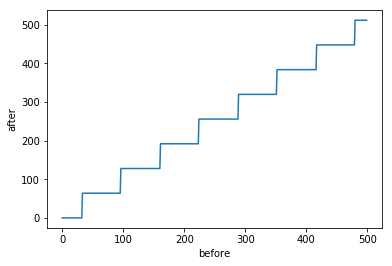

In [7]:
a = numpy.arange(500).astype('float32')
b = (a + 1e9) - 1e9
plt.plot(a, b)
plt.xlabel('before')
plt.ylabel('after')

Text(0, 0.5, 'after')

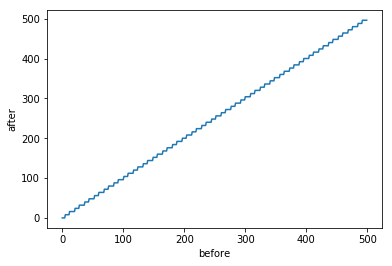

In [8]:
a = numpy.arange(500).astype('float32')
b = (a + 1e8) - 1e8
plt.plot(a, b)
plt.xlabel('before')
plt.ylabel('after')

### Comments

* The `float32` and `float64` number representations have a certain budget of bits to represent real numbers. Therefore, they allocate precision where it is important (e.g. for small numbers).

* The smaller the precision, the less memory is used and therefore the more efficient, but also the more careful we should be about potential loss of precision.

* Unlike typical observed data, error is not random-looking, but very structured:

Text(0, 0.5, 'output error')

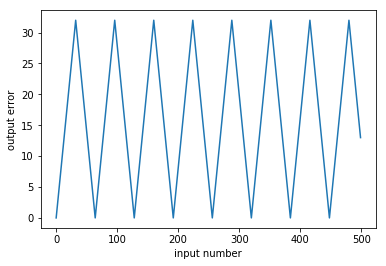

In [9]:
a = numpy.arange(500).astype('float32')
error = numpy.abs(a - ((a + 1e9) - 1e9))
plt.plot(a, error)
plt.xlabel('input number')
plt.ylabel('output error')

## Overflow

Overflow is a frequently encountered problem when implementing machine learning algorithms.

In [10]:
a = numpy.array([1, 10, 100, 1000], dtype='float32')

print(numpy.exp(a))

[2.7182817e+00 2.2026465e+04           inf           inf]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


### The sigmoid function

![plot generated by fooplot.com](sigmoid.png)

$$
\mathrm{sigmoid}(x) = \frac{\exp(x)}{1+\exp(x)}
$$

In [11]:
X = numpy.array([-1e9, -1e6, -1e3, -1e1, 2, 1, 0, 1, 2, 1e1, 1e3, 1e6, 1e9],dtype='float32')

def sigmoid(x):
    return numpy.exp(x) / (1 + numpy.exp(x))

print(sigmoid(X))

[0.000000e+00 0.000000e+00 0.000000e+00 4.539787e-05 8.807971e-01
 7.310586e-01 5.000000e-01 7.310586e-01 8.807971e-01 9.999546e-01
          nan          nan          nan]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Where does the `nan` come from?

In [12]:
print(numpy.exp(1000))

inf


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [13]:
print(float('inf') / float('inf'))

nan


### The sigmoid function (2)

Let's rewrite the sigmoid function in a different way

$$
\mathrm{sigmoid}(x) = \frac{\exp(x)}{1+\exp(x)} = \frac{\exp(-x) \exp(x)}{\exp(-x) (1+\exp(x))} = \frac{1}{1+\exp(-x)}
$$

In [14]:
def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))

print(sigmoid(X))

[0.0000000e+00 0.0000000e+00 0.0000000e+00 4.5397872e-05 8.8079703e-01
 7.3105860e-01 5.0000000e-01 7.3105860e-01 8.8079703e-01 9.9995458e-01
 1.0000000e+00 1.0000000e+00 1.0000000e+00]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Here, we still get an overflow. But this time, we are lucky since 1/inf = 0.0, which is the desired result for large negative inputs.

In [15]:
1.0 / float('inf')

0.0

### The sigmoid function (3)


The sigmoid function can be written in yet another way:

$$
\mathrm{sigmoid}(x) = \frac{\exp(x)}{1+\exp(x)} = \frac{1}{2}\Big(\frac{2\exp(x)}{1+\exp(x)}\Big) = \frac{1}{2}\Big(\frac{\exp(x) - 1 + 1 + \exp{(x)}}{1+\exp(x)}\Big) = \frac{1}{2}\Big( \frac{\exp{(x)} - 1}{\exp{(x)}+1} + 1\Big) = \frac{1}{2}\Big( \tanh(\frac{x}{2}) + 1\Big)
$$

$$
\tanh{(x)} = \frac{\exp{(2x) - 1}}{\exp{(2x) + 1}}
$$

In [16]:
def sigmoid(x):
    return 0.5 * ( numpy.tanh(0.5 * x) + 1 )

print(sigmoid(X))

[0.0000000e+00 0.0000000e+00 0.0000000e+00 4.5388937e-05 8.8079709e-01
 7.3105860e-01 5.0000000e-01 7.3105860e-01 8.8079709e-01 9.9995458e-01
 1.0000000e+00 1.0000000e+00 1.0000000e+00]


And there is no runtime warning this time.

### The sigmoid function (4)

Suppose we cannot use the tanh function. The sigmoid function can alternatively be approximated to avoid the overflow:

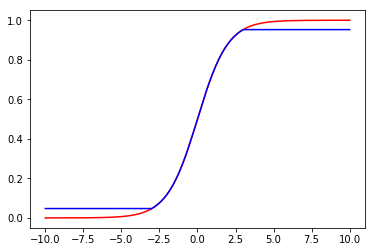

In [17]:
X = numpy.arange(-10, 10.01, 0.1)

plt.plot(X, sigmoid(X), 'r')
plt.plot(X, sigmoid(numpy.clip(X, -3, 3)), 'b')

The numpy clip function prevents the input from going outside a certain interval. This effectively avoids overflow in the exponential, but also causes a small approximation error.

### Another source of overflow: normalizing probability distributions

Many probability functions can be written this way:
$$
p(x) = \frac1Z \exp(f(x))
$$

* Example of such functions: Gaussian distribution, Gibbs distribution.

* Machine learning algorithms often use these distributions, because their parameters can be learned easily. For example, the mean parameter of a Gaussian distribution can be learned by computing the empirical mean of the data, and the scale parameter can be learned by computing the empirical standard deviation.

* On the other hand, these probability functions have a risk of overflow due to the exponential function.

In [18]:
# Let p(x) be a discrete distribution with function values
f = numpy.array([1.0, 8.0, 100.0, 0.1, 3.5, 2.3], dtype='float32')

# The normalization factor is the sum of these function values
# after application of the exponential function
Z = numpy.exp(f).sum()

print(Z)

inf


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Even taking the logarithm of `Z` won't solve the overflow.

In [19]:
print(numpy.log(Z))

inf


This problem will be studied in the homework.

## Linear Algebra

Many machine learning techniques are based on linear algebra. Two important ones are linear regression and principal component analysis. These techniques can be implemented easily in Python and Numpy.

### Linear regression

The model assumes that the data is generated as following:

$$
y_n = \beta_1 x_n + \beta_2 + \epsilon_n, \quad n = \overline{1..N},\quad \epsilon_n \sim \mathcal{N}(0,\sigma^2)
$$

or

$$
y = \beta_1\hat{X} + \beta_2\mathbb{1}_{N} + \mathcal{E}, \quad \text{where}  \quad y, \hat{X} , \mathcal{E} \in \mathbb{R}^{(N)} 
$$

$$
y = [ \beta_1, \beta_2 ] \times [ \hat{X} , \mathbb{1}_{N}]^{\top} + \mathcal{E}
$$

$$
y = \beta \times {X}^{\top} + \mathcal{E}, \quad \text{where} \quad \beta = [\beta_1,\beta_2] \in \mathbb{R}^{(2)}, \quad \text{and} \quad X = [ \hat{X} , \mathbb{1}_{N}] \in \mathbb{R}^{(N,2)}
$$

Finding the best linear fit of a labeled dataset.

(250, 2)


Text(0, 0.5, 'y')

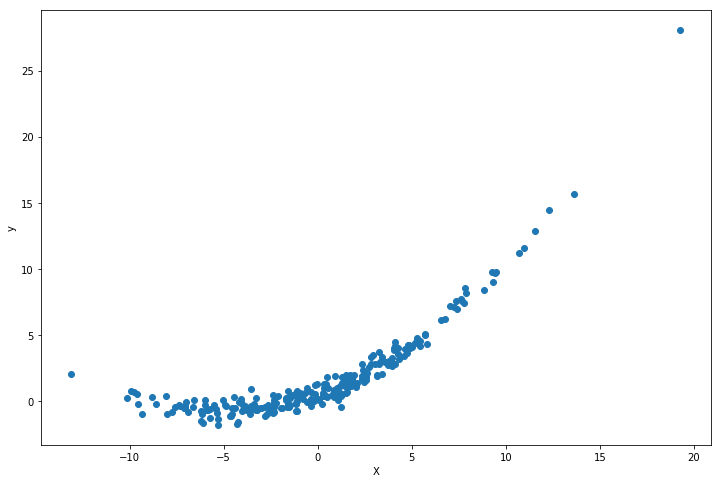

In [20]:
# Create a dataset

#Fix the random seed

numpy.random.seed(42)

N = 250 # number of data points

X = numpy.random.normal(0, 5, size = (N, 1))
X_ones = numpy.ones_like(X)

X = numpy.concatenate((X, X_ones), axis=1)
print(X.shape)

plt.figure(figsize = (12,8))

# Create targets (outputs) and make them depend on X in some way
y = 0.5 * X[:, 0] + 0.05 * X[:, 0] ** 2 + 0.5

sigma2 = 0.5

Eps = numpy.random.normal(0, sigma2, (N)) # random noise

y += Eps # add noise to the targets

# Plot the labeled dataset
plt.scatter(X[:, 0], y)
plt.xlabel('X')
plt.ylabel('y')

Split dataset randomly into *train* and *test* datasets

In [21]:
# set split ratio
split_ratio = 0.8 # 80 % for train and 20 % for test

idx = numpy.arange(N) # create all indexes
numpy.random.shuffle(idx) # shuffle them

split_idx =int(split_ratio*N)
# create train and test indexes
tr_idx = idx[:split_idx]
te_idx = idx[split_idx:]

print((len(tr_idx), len(te_idx)))

# create Train dataset
X_tr = X[tr_idx]
y_tr = y[tr_idx]

# create Test dataset
X_te = X[te_idx]
y_te = y[te_idx]


(200, 50)


The parameter of the model is given by:
$$\beta = (X_\text{tr}^\top X_\text{tr})^{-1} X_\text{tr}^\top y_\text{tr}$$

And the prediction for new "test" points by:
$$\hat y_\text{te} = X_\text{te} \beta$$

Text(0, 0.5, 'y')

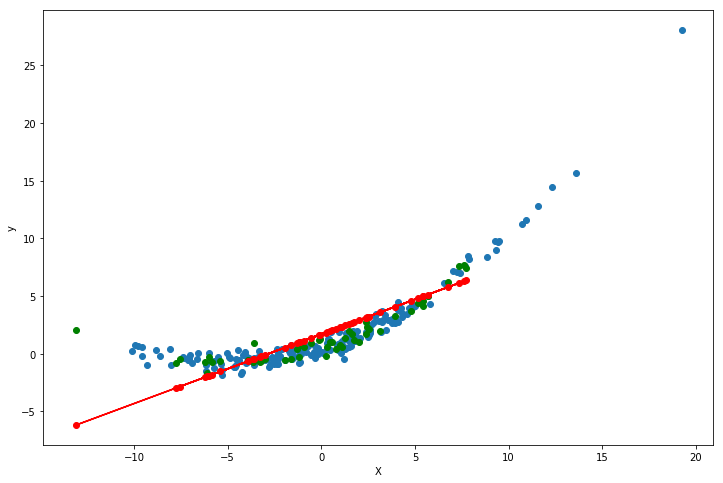

In [22]:
import numpy.linalg

# Learn the model parameter
beta = numpy.dot(numpy.dot(numpy.linalg.inv(numpy.dot(X_tr.T, X_tr)), X_tr.T), y_tr)

# Equivalent expression
beta_short = numpy.linalg.inv(X_tr.T.dot(X_tr)).dot(X_tr.T.dot(y_tr))

# check if the results are numerically the same 
assert numpy.allclose(beta, beta_short)

# Predict outputs for the test data
y_te_predict = numpy.dot(X_te, beta)

plt.figure(figsize = (12,8))

# Plot the data and the prediction
plt.scatter(X_tr[:, 0], y_tr)
plt.scatter(X_te[:, 0], y_te, color='g')
plt.xlabel('X')
plt.ylabel('y')

plt.plot(X_te[:, 0],y_te_predict, 'o-', color='r')
plt.xlabel('X')
plt.ylabel('y')

Compute the *root mean square error* (RMSE) for the predicted outputs:

$\text{RMSE} = \sqrt{\frac{1}{N}\sum_{n=1}^N(\hat{y}_{\text{te}_n} - y_{\text{te}_n} )^2}$

In [23]:
rmse = numpy.sqrt(numpy.square(y_te_predict - y_te).mean())
print("RMSE: {:0.3f} where y_tr variance: {:0.2f}".format(rmse, numpy.var(y_tr)))

RMSE: 1.619 where y_tr variance: 12.49


### Principal component analysis (PCA)

PCA is a technique widely used for applications such as
dimensionality reduction
 - lossy data compression
 - feature extraction
 - data visualization

There are two commonly used definitions of PCA:
 - Orthogonal projection onto lower dimensional linear space
    such that the variance of projected data is maximized.
    
 - Linear projection that minimizes the average projection
    cost, defined as the mean squared distance between the
    data and their projections.

[-30, 30, -30, 30]

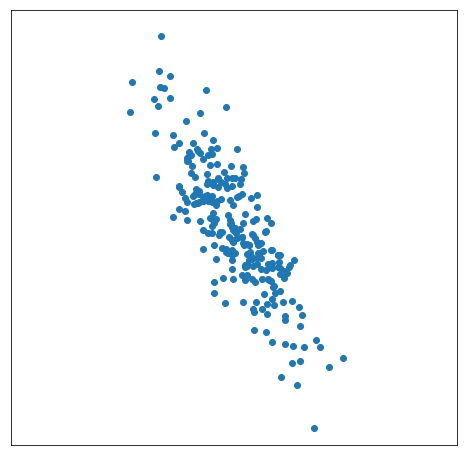

In [35]:
# create a random dataset
N = 250
M = numpy.random.normal(0, 5, (N, 2))

# create some relation between dimensions
M[:, 1] -= 1.5 * M[:, 0]

# PCA only applies to centered data, so we center the data
M -= M.mean(axis=0)


# Plot the centered dataset
plt.figure(figsize=(8, 8))
plt.scatter(M.T[0], M.T[1])

# Turn off axis ticks
plt.xticks([])
plt.yticks([])

plt.axis([-30, 30, -30, 30])

## Singular value decomposition (SVD)

The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make e.g. certain subsequent matrix calculations like matrix inversion simpler.

![](SVD.png)

U shape:  (250, 2)
Sigma shape: (2,)
V shape: (2, 2)


[-30, 30, -30, 30]

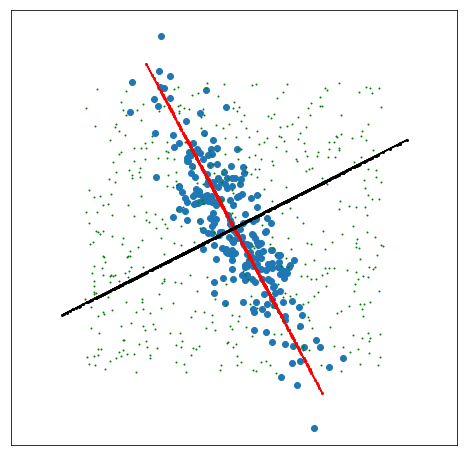

In [45]:
# Find the principal components
U, Sigma, V = numpy.linalg.svd(M , full_matrices = False)

print("U shape: ", U.shape)
print("Sigma shape:", Sigma.shape)
print("V shape:", V.shape)

X = U.dot(numpy.diag(Sigma).dot(V.T))

assert numpy.allclose(numpy.sum(M - X) , numpy.zeros_like(M))

HAT1 = numpy.outer(V[0], V[0]) # projection matrix to the axis representing the most data variance

HAT2 = numpy.outer(V[1], V[1]) # projection matrix to the axis representing the second most data variance


Mtest    = numpy.random.uniform(-20, 20, (500, 2))

# Project some test data onto the fisrt principal compenent
MtestPCA1 = numpy.dot(Mtest, HAT1)

# Project some test data onto the second principal compenent
MtestPCA2 = numpy.dot(Mtest, HAT2)

# Plot the original data and the projected test data
plt.figure(figsize=(8, 8))

plt.scatter(*M.T)  # equivalent to M.T[0], M.T[1]

plt.plot(*Mtest.T, 'o', color='g', ms=1)
plt.plot(*MtestPCA1.T, 'o-', color='r', ms=2)
plt.plot(*MtestPCA2.T, 'o-', color='k', ms=2)

plt.xticks([])
plt.yticks([])

plt.axis([-30, 30, -30, 30])